In [43]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import math
from scipy import fftpack
from scipy.integrate import quad, quadrature
import pandas as pd
from math import sqrt
from scipy.signal import find_peaks
from matplotlib.colors import LogNorm
from scipy.interpolate import interp1d
import matplotlib.image as mpimg

1\. **Hurricanes per Year**

The number of hurricanes in 2005 was 15. The historic average is 6.3. Is this number signficantly different?
- Assume the number of hurricanes is random, i.e. follows the Poisson distribution.
- Assume as statistically significant a probability that has a Z score of 3 or larger with respect a normal distribution.

**Hint**: compute the probability that in a single year are observed 15 or more hurricances.

In [44]:
# assuming as null hypothesis a poisson distribution with mean = 6.3, 
# normal for large samples with mean = 6.3, and std  = 6.3

value = 15
mean = 6.3

# determining the Z score
std = np.sqrt(mean)
Z = (value - mean) / std

print('Z score is:', Z)

# determining the pdf
pdf = stats.poisson.sf(k = value - 1, mu = mean)
distribution = 1 - pdf.sum()

print('\nThe probability of happening', value, 'hurricanes in a year is:' , pdf)
print('\nThe distribution is:', distribution)

# determining the pdf
p_value = 1-stats.norm.cdf(Z) 

print('\nP-value is: ', p_value)
print('\nSince the Z score is more than 3, assuming a Poisson distribution, 15 hurricanes is a \
significantly different number from the historic average.')

Z score is: 3.4661629670697414

The probability of happening 15 hurricanes in a year is: 0.002217122790073146

The distribution is: 0.9977828772099269

P-value is:  0.00026397158691493505

Since the Z score is more than 3, assuming a Poisson distribution, 15 hurricanes is a significantly different number from the historic average.


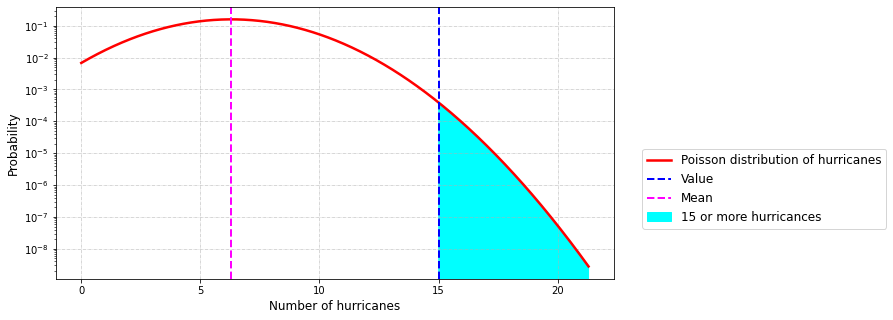

In [45]:
# plotting the measurement and its assumed pdf

x = np.linspace(0, mean + 15, 1000)
y = stats.norm.pdf(x, loc = mean, scale = std)
w = np.abs(mean - value)

plt.figure(figsize = (10, 5))
plt.plot(x, y, label = 'Poisson distribution of hurricanes', color = 'red', lw = 2.5)
plt.fill_between(x, y, where = x >= value, color = 'cyan', label = '15 or more hurricances')

plt.axvline(x = value, color = 'blue', linestyle = '--', lw = 2, label = 'Value')
plt.axvline(x = mean, color = 'magenta', linestyle = '--', lw = 2, label = 'Mean')

plt.yscale('log')
plt.xlabel('Number of hurricanes', fontsize = 12)
plt.ylabel('Probability', fontsize = 12)
plt.legend(fontsize = 12, bbox_to_anchor=(1.04, 0.5))
plt.grid(linestyle = 'dashdot', linewidth = 0.5)
plt.show()



2\. **Pairwise t-test**

In an experiment, a group of 10 individuals agreed to participate in a study of blood pressure changes following exposure to halogen lighting. Resting systolic blood pressure was recorded for each individual. The participants were then exposed to 20 minutes in a room lit only by halogen lamps. A post-exposure systolic blood pressure reading was recorded for each individual. The results are presented in the following data set:

```python
pre = np.array([120, 132, 120, 110, 115, 128, 120, 112, 110, 100])
post = np.array([140, 156, 145, 130, 117, 148, 137, 119, 127, 135])
```

Determine whether the change in blood pressures within our sample was statistically significant.

**Hint:**
in this case, the Student's $t$-test should be performed to compare the two datasets.
Use the following test statistics:

$$T = \frac{\bar{x}_1 - \bar{x}_2}{\sigma \sqrt{\frac{2}{n}}}$$

and 

$$\sigma = \sqrt{\frac{\sigma_1^2 + \sigma_2^2}{2}}$$

In [46]:
pre = np.array([120, 132, 120, 110, 115, 128, 120, 112, 110, 100])
post = np.array([140, 156, 145, 130, 117, 148, 137, 119, 127, 135])

# Determining whether the change is statistically significant

mean_pre = np.mean(pre) 
mean_post = np.mean(post) 

std_pre = np.sqrt(np.var(pre, ddof = 1)) 
std_post = np.sqrt(np.var(post, ddof = 1))
total_std = np.sqrt((std_pre ** 2 + std_post ** 2)  / 2)

print('Pre-exposure Mean:', mean_pre)
print('Post-exposure Mean:', mean_post)
print('Pre-exposure Standard Deviation:', std_pre)
print('Post-exposure Standard Deviation:', std_post)
print('Total Standard Deviation:', total_std)

Pre-exposure Mean: 116.7
Post-exposure Mean: 135.4
Pre-exposure Standard Deviation: 9.357706271660096
Post-exposure Standard Deviation: 12.500666648889837
Total Standard Deviation: 11.04158805003459


In [47]:
# calculating the test statistics 'T'

n = len(pre)  # size of the pre-dataset
w = (np.mean(pre) - np.mean(post))
T = w / (total_std * np.sqrt(2 / n))  # We can also use: T, P = stats.ttest_ind(pre, post) 

print('T =', T)


# computing the p-value

ndof = n + n-2   # number of degrees of freedom 
p_value = stats.t.cdf( -np.abs(T), ndof) + (1 - stats.t.cdf(np.abs(T), ndof))   # two-sided test

print('\nP-value =', p_value)

T = -3.786997938137629

P-value = 0.0013499418313276546


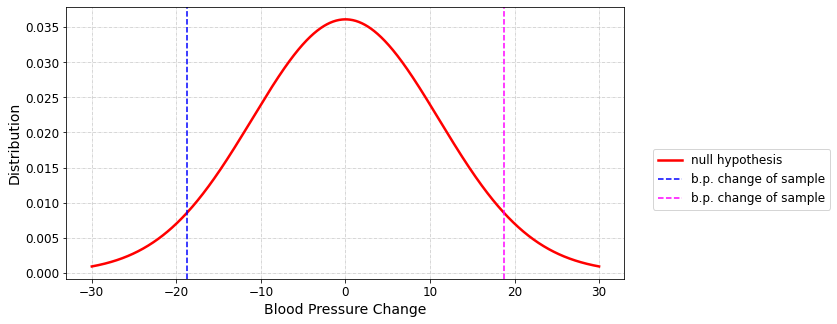

In [48]:
x = np.linspace(-30, 30, 1000)
y = stats.norm.pdf(x, loc = 0, scale = total_std)

plt.figure(figsize = (10, 5))
plt.plot(x, y, label = 'null hypothesis', color = 'red', lw = 2.5)
plt.axvline(x = w, label = 'b.p. change of sample', color = 'blue', linestyle = '--')
plt.axvline(x = -w, label = 'b.p. change of sample', color = 'magenta', linestyle = '--')

plt.grid(linestyle = 'dashdot', linewidth = 0.5)
plt.xlabel('Blood Pressure Change', fontsize = 14)
plt.ylabel('Distribution', fontsize = 14)
plt.tick_params(labelsize = 12)
plt.legend(fontsize = 12, bbox_to_anchor=(1.04, 0.5))
plt.show()

3\. **FFT of a simple dataset**

Perform a periodicity analysis on the lynxs-hares population, i.e. determine what is the period of the population of these animals.

In [49]:
# loading the dataset 'populations.txt' into a pandas DataFrame 'df'

data_frame = pd.read_csv('populations.txt', delimiter = '\t')
dataset = np.loadtxt('populations.txt')
years, hares, lynxes, carrots = dataset[:, 0], dataset[:, 1], dataset[:, 2], dataset[:, 3]

display(data_frame)

,# year,hare,lynx,carrot
0,1900,30000.0,4000.0,48300
1,1901,47200.0,6100.0,48200
2,1902,70200.0,9800.0,41500
3,1903,77400.0,35200.0,38200
4,1904,36300.0,59400.0,40600
5,1905,20600.0,41700.0,39800
6,1906,18100.0,19000.0,38600
7,1907,21400.0,13000.0,42300
8,1908,22000.0,8300.0,44500
9,1909,25400.0,9100.0,42100


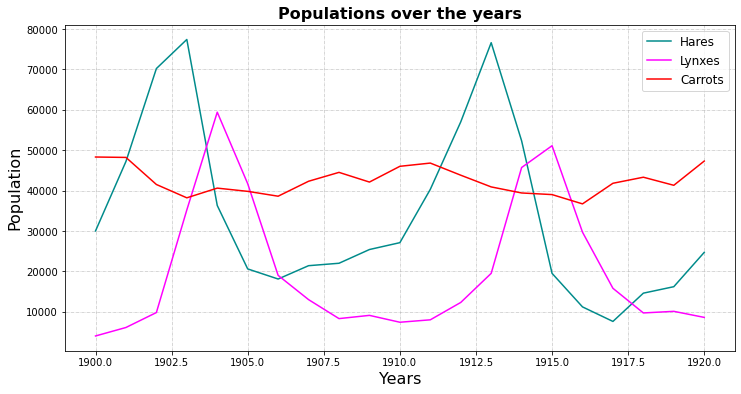

In [50]:
# plotting the three populations over the years

plt.figure(figsize = (12, 6))

plt.plot(years, hares, color = 'darkcyan', label = 'Hares')
plt.plot(years, lynxes, color = 'magenta', label = 'Lynxes')
plt.plot(years, carrots, color = 'red', label = 'Carrots')

plt.title('Populations over the years', fontsize = 16, fontweight = 'bold')
plt.xlabel('Years', fontsize=16)
plt.ylabel('Population', fontsize=16)
plt.grid(linestyle = 'dashdot', linewidth = 0.5)
plt.legend(fontsize = 12)

plt.show()

In [51]:
# computing the FFT of the dataset

hare_fft = fftpack.fft(list(hares))
lynxe_fft = fftpack.fft(list(lynxes))
carrot_fft = fftpack.fft(list(carrots))
dataframe_fft = pd.DataFrame([hare_fft, lynxe_fft, carrot_fft], index = ['hare_fft', 'lynxe_fft', 'carrot_fft'])
dataframe_fft = dataframe_fft.T

print('\nFFT of the dataset:\n')
display(dataframe_fft)



FFT of the dataset:



,hare_fft,lynxe_fft,carrot_fft
0,7157000000000.0-0.00000000j,4235000000000.0-0.00000000j,890400000000.0-0.0000000j
1,-12514.069528-41299.484332j,-4543.15033200-2873.35518400j,4728.1641290-2078.1745740j
2,89297.433585-255500.904180j,-174675.133391-110711.233158j,41123.247402+8996.081996j
3,5643.5575710+2259.9935060j,-14254.4391680+8839.3092830j,5331.2723840+2692.9477060j
4,-129841.666074-17562.146221j,23006.147290+108899.205746j,8970.5555540-7239.7539240j
5,-4257.7476060+7223.4974150j,5889.236354+011288.6416120j,7440.0304210-2552.6079670j
6,3414.515460+051911.0534960j,20587.8195760-39284.1202630j,11610.604300-10447.619937j
7,5150.0000000+1472.2431860j,-1150.00000000-6321.98544800j,-5250.0000000+4416.7295590j
8,23362.8738850-8859.6377690j,-24698.9466630+1829.9683510j,-2978.0625580+6975.2968820j
9,-3958.0730310+3108.0466980j,1366.61959300-1870.69682000j,-7141.8766840-1140.2939540j


In [52]:
# computing the power spectral density (PSD)

hare_psd = (np.abs(hare_fft)) ** 2
lynxe_psd = (np.abs(lynxe_fft)) ** 2
carrot_psd = (np.abs(carrot_fft)) ** 2

dataframe_psd = pd.DataFrame([hare_psd, lynxe_psd, carrot_psd], index = ['hare_psd', 'lynxe_psd', 'carrot_psd'])
dataframe_psd = dataframe_psd.T

print('\nPower Spectral Density (PSD):\n')
display(dataframe_psd)


Power Spectral Density (PSD):



,hare_psd,lynxe_psd,carrot_psd
0,5.122265e+11,1.793522e+11,7.928122e+11
1,1.862249e+09,2.889638e+07,2.667435e+07
2,7.325474e+10,4.276838e+10,1.772051e+09
3,3.695731e+07,2.813224e+08,3.567443e+07
4,1.716729e+10,1.238832e+10,1.328849e+08
5,7.030733e+07,1.621165e+08,6.186986e+07
6,2.706416e+09,1.967100e+09,2.439589e+08
7,2.869000e+07,4.129000e+07,4.707000e+07
8,6.243171e+08,6.133868e+08,5.752362e+07
9,2.532630e+07,5.367156e+06,5.230667e+07


In [53]:
# computing the frequency for each year

year_freq = fftpack.fftfreq(years.size, d = 1)

dataframe_freq_fft = pd.DataFrame([dataset[:, 0], year_freq, hare_fft, lynxe_fft, carrot_fft], index = ['year','frequency', 'hare_fft', 'lynxe_fft', 'carrot_fft'])
dataframe_freq_fft = dataframe_freq_fft.T

dataframe_freq_psd = pd.DataFrame([dataset[:, 0], year_freq, hare_psd, lynxe_psd, carrot_psd], index = ['year','frequency', 'hare_psd', 'lynxe_psd', 'carrot_psd'])
dataframe_freq_psd = dataframe_freq_psd.T

print('\nFrequencies corresponding to the values of the fft:\n')
display(dataframe_freq_fft)
print('\nFrequencies corresponding to the values of the PSD:\n')
display(dataframe_freq_psd)


Frequencies corresponding to the values of the fft:



,year,frequency,hare_fft,lynxe_fft,carrot_fft
0,1900.0+0.0j,0.000000+0.000000j,7157000000000.0-0.00000000j,4235000000000.0-0.00000000j,890400000000.0-0.0000000j
1,1901.0+0.0j,0.047619+0.000000j,-12514.069528-41299.484332j,-4543.15033200-2873.35518400j,4728.1641290-2078.1745740j
2,1902.0+0.0j,0.095238+0.000000j,89297.433585-255500.904180j,-174675.133391-110711.233158j,41123.247402+8996.081996j
3,1903.0+0.0j,0.142857+0.000000j,5643.5575710+2259.9935060j,-14254.4391680+8839.3092830j,5331.2723840+2692.9477060j
4,1904.0+0.0j,0.190476+0.000000j,-129841.666074-17562.146221j,23006.147290+108899.205746j,8970.5555540-7239.7539240j
5,1905.0+0.0j,0.238095+0.000000j,-4257.7476060+7223.4974150j,5889.236354+011288.6416120j,7440.0304210-2552.6079670j
6,1906.0+0.0j,0.285714+0.000000j,3414.515460+051911.0534960j,20587.8195760-39284.1202630j,11610.604300-10447.619937j
7,1907.0+0.0j,0.333333+0.000000j,5150.0000000+1472.2431860j,-1150.00000000-6321.98544800j,-5250.0000000+4416.7295590j
8,1908.0+0.0j,0.380952+0.000000j,23362.8738850-8859.6377690j,-24698.9466630+1829.9683510j,-2978.0625580+6975.2968820j
9,1909.0+0.0j,0.428571+0.000000j,-3958.0730310+3108.0466980j,1366.61959300-1870.69682000j,-7141.8766840-1140.2939540j



Frequencies corresponding to the values of the PSD:



,year,frequency,hare_psd,lynxe_psd,carrot_psd
0,1900.0,0.000000,5.122265e+11,1.793522e+11,7.928122e+11
1,1901.0,0.047619,1.862249e+09,2.889638e+07,2.667435e+07
2,1902.0,0.095238,7.325474e+10,4.276838e+10,1.772051e+09
3,1903.0,0.142857,3.695731e+07,2.813224e+08,3.567443e+07
4,1904.0,0.190476,1.716729e+10,1.238832e+10,1.328849e+08
5,1905.0,0.238095,7.030733e+07,1.621165e+08,6.186986e+07
6,1906.0,0.285714,2.706416e+09,1.967100e+09,2.439589e+08
7,1907.0,0.333333,2.869000e+07,4.129000e+07,4.707000e+07
8,1908.0,0.380952,6.243171e+08,6.133868e+08,5.752362e+07
9,1909.0,0.428571,2.532630e+07,5.367156e+06,5.230667e+07


In [54]:
# focusing only on the positive frequencies

posetive_freq_fft = (dataframe_freq_fft['frequency'] > 0)
dataframe_freq_fft = dataframe_freq_fft[posetive_freq_fft]

print('\nPosetive Frequencies:\n')
display(posetive_freq_fft)

print('\nFilterd dataframe consist of posetive Frequencies corresponding to the values of the FFT:\n')
display(dataframe_freq_fft)

posetive_freq_psd = (dataframe_freq_psd['frequency'] > 0)
dataframe_freq_psd = dataframe_freq_psd[posetive_freq_psd]

print('\nFilterd dataframe consist of posetive Frequencies corresponding to the values of the PSD:\n')
display(dataframe_freq_psd)



Posetive Frequencies:



0     False
1      True
2      True
3      True
4      True
5      True
6      True
7      True
8      True
9      True
10     True
11    False
12    False
13    False
14    False
15    False
16    False
17    False
18    False
19    False
20    False
Name: frequency, dtype: bool


Filterd dataframe consist of posetive Frequencies corresponding to the values of the FFT:



,year,frequency,hare_fft,lynxe_fft,carrot_fft
1,1901.0+0.0j,0.047619+0.000000j,-12514.069528-41299.484332j,-4543.15033200-2873.35518400j,4728.1641290-2078.1745740j
2,1902.0+0.0j,0.095238+0.000000j,89297.433585-255500.904180j,-174675.133391-110711.233158j,41123.247402+8996.081996j
3,1903.0+0.0j,0.142857+0.000000j,5643.5575710+2259.9935060j,-14254.4391680+8839.3092830j,5331.2723840+2692.9477060j
4,1904.0+0.0j,0.190476+0.000000j,-129841.666074-17562.146221j,23006.147290+108899.205746j,8970.5555540-7239.7539240j
5,1905.0+0.0j,0.238095+0.000000j,-4257.7476060+7223.4974150j,5889.236354+011288.6416120j,7440.0304210-2552.6079670j
6,1906.0+0.0j,0.285714+0.000000j,3414.515460+051911.0534960j,20587.8195760-39284.1202630j,11610.604300-10447.619937j
7,1907.0+0.0j,0.333333+0.000000j,5150.0000000+1472.2431860j,-1150.00000000-6321.98544800j,-5250.0000000+4416.7295590j
8,1908.0+0.0j,0.380952+0.000000j,23362.8738850-8859.6377690j,-24698.9466630+1829.9683510j,-2978.0625580+6975.2968820j
9,1909.0+0.0j,0.428571+0.000000j,-3958.0730310+3108.0466980j,1366.61959300-1870.69682000j,-7141.8766840-1140.2939540j
10,1910.0+0.0j,0.476190+0.000000j,-19146.824262-12426.362328j,-1278.15325700+936.72661600j,-1883.9349480+739.6541520j



Filterd dataframe consist of posetive Frequencies corresponding to the values of the PSD:



,year,frequency,hare_psd,lynxe_psd,carrot_psd
1,1901.0,0.047619,1.862249e+09,2.889638e+07,2.667435e+07
2,1902.0,0.095238,7.325474e+10,4.276838e+10,1.772051e+09
3,1903.0,0.142857,3.695731e+07,2.813224e+08,3.567443e+07
4,1904.0,0.190476,1.716729e+10,1.238832e+10,1.328849e+08
5,1905.0,0.238095,7.030733e+07,1.621165e+08,6.186986e+07
6,1906.0,0.285714,2.706416e+09,1.967100e+09,2.439589e+08
7,1907.0,0.333333,2.869000e+07,4.129000e+07,4.707000e+07
8,1908.0,0.380952,6.243171e+08,6.133868e+08,5.752362e+07
9,1909.0,0.428571,2.532630e+07,5.367156e+06,5.230667e+07
10,1910.0,0.476190,5.210154e+08,2.511133e+06,4.096299e+06


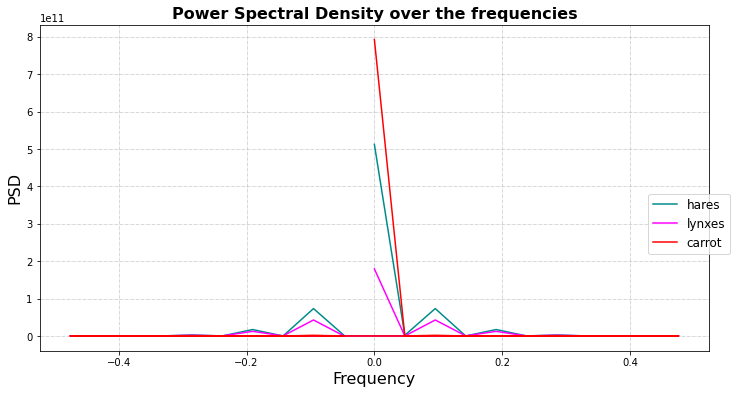

In [55]:
# plotting psd over the frequency

plt.figure(figsize = (12, 6))

plt.plot(year_freq, hare_psd, color = 'darkcyan', label = 'hares')
plt.plot(year_freq, lynxe_psd, color = 'magenta', label = 'lynxes')
plt.plot(year_freq, carrot_psd, color = 'red', label = 'carrot')


plt.title('Power Spectral Density over the frequencies', fontsize = 16, fontweight = 'bold')
plt.xlabel('Frequency', fontsize=16)
plt.ylabel('PSD', fontsize = 16)
plt.grid(linestyle = 'dashdot', linewidth = 0.5)
plt.legend(fontsize = 12, bbox_to_anchor = (1.04, 0.5))

plt.show()


In [56]:
posetive_freq_fft = np.where(year_freq > 0)
year_freq_fft = year_freq[posetive_freq_fft]

In [57]:
# finding the peak frequency and the period of each population


 # HARE:
 
peak_freq_hare = year_freq_fft[hare_psd[posetive_freq_fft].argmax()]

print('\n\tHARE:\n')
print('Peak frequency hare =', peak_freq_hare)
print('period hare = ', 1 / peak_freq_hare)

 # LYNXE:
    
peak_freq_lynxe = year_freq_fft[lynxe_psd[posetive_freq_fft].argmax()]

print('\n\tLYNXE:\n')
print('Peak frequency lynxe =', peak_freq_lynxe)
print('period lynxe = ', 1 / peak_freq_lynxe)
    
    
  # CARROT:
    
peak_freq_carrot = year_freq_fft[carrot_psd[posetive_freq_fft].argmax()]

print('\n\tCARROT:\n')
print('Peak frequency carrot =', peak_freq_carrot)
print('period carrot = ', 1 / peak_freq_carrot)



	HARE:

Peak frequency hare = 0.09523809523809523
period hare =  10.5

	LYNXE:

Peak frequency lynxe = 0.09523809523809523
period lynxe =  10.5

	CARROT:

Peak frequency carrot = 0.09523809523809523
period carrot =  10.5


In [58]:
# cleaning the dataset for each categories

 # HARE:
fcleaned_hare = hare_fft.copy()
fcleaned_hare[np.abs(year_freq) > peak_freq_hare] = 0
cleaned_hare = fftpack.ifft(list(fcleaned_hare))
real_clean_hare = np.real(cleaned_hare)

 # LYNXE:
fcleaned_lynxe =lynxe_fft.copy()
fcleaned_lynxe[np.abs(year_freq) > peak_freq_lynxe] = 0
cleaned_lynxe = fftpack.ifft(list(fcleaned_lynxe))
real_clean_lynxe = np.real(cleaned_lynxe)

 # CARROT:
fcleaned_carrot = hare_fft.copy()
fcleaned_carrot[np.abs(year_freq) > peak_freq_carrot] = 0
cleaned_carrot = fftpack.ifft(list(fcleaned_carrot))
real_clean_carrot = np.real(cleaned_carrot)


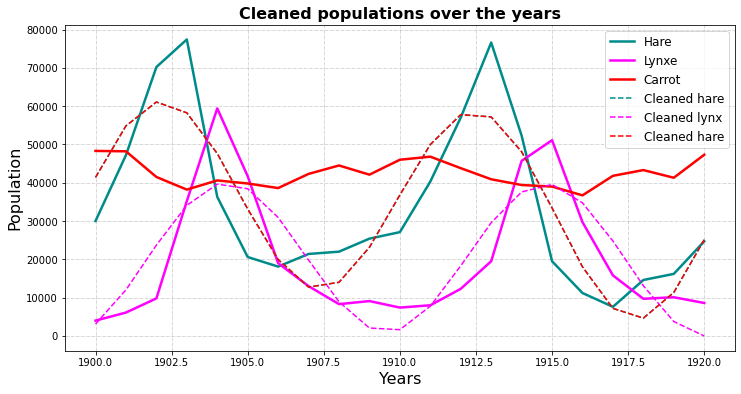

In [59]:
plt.figure(figsize = (12, 6))

plt.plot(years, hares, color = 'darkcyan', label = 'Hare', lw = 2.5)
plt.plot(years, lynxes, color = 'magenta', label = 'Lynxe', lw = 2.5)
plt.plot(years, carrots, color = 'red', label = 'Carrot', lw = 2.5)

plt.title('Cleaned populations over the years', fontsize = 16, fontweight = 'bold')
plt.xlabel('Years', fontsize = 16)
plt.ylabel('Population', fontsize = 16)

plt.plot(years, real_clean_hare, color = 'darkcyan', label = 'Cleaned hare', linestyle = '--')
plt.plot(years, real_clean_lynxe, color = 'magenta', label = 'Cleaned lynx', linestyle = '--')
plt.plot(years, real_clean_carrot, color = 'red', label = 'Cleaned hare', linestyle = '--')

plt.grid(linestyle = 'dashdot', linewidth = 0.5)
plt.legend(fontsize = 12)
plt.show()

4\. **FFT of an image**

Write a filter that removes the periodic noise from the `moonlanding.png` image by using a 2-dimensional FFT.

* Import the image as a 2D numpy array using `plt.imread("moonlanding.png")`. Examine the image with `plt.imshow()`, which is heavily contaminated with periodic noise.
* Check the documentation of the `scipy.fftpack` package, and find the method that performs a 2D FFT. Plot the spectrum (Fourier transform of) the image. **Hint**: use `LogNorm` to plot the colors in log scale:
```Python
from matplotlib.colors import LogNorm
plt.imshow(image, norm=LogNorm(vmin=5))
```
* Inspect the spectrum, and try to locate the regions of the power spectrum that contain the signal and those which contain the periodic noise. Use array slicing to set the noise regions to zero.
* Apply the inverse Fourier transform to plot the resulting image.

In [94]:
# importing the image as a 2D NumPy array


im = plt.imread('moonlanding.png')

im = plt.imread('d:/G/Books/Geophysics/Padova University/Semester 3/HIGH LEVEL PROGRAMMING/Data/moonlanding.png')



FileNotFoundError: [Errno 2] No such file or directory: 'moonlanding.png'

In [62]:
# I have uploaded this png image in my repository but I dose not import here. 
# I have tried several time with series of codes. Unfortunately it dose not work at all.
# I am so sorry about that. Actually, this part is very important for me because I have to work on images specially 
# with Fourier analaysis in my feild of work, since I am coming from the Geoscience Department. I am really 
# interested to fint out my mistak in importing this kink of images. Dear Professor, I realyy need your help
# in this order. Thank you in advance.
